# Kalman Filter for Noisy Pendulum

In this example we will study a simplified nonlinear system of differential equations, the nonlinear pendulum, and apply Kalman filters in an attempt to do tracking, and eventually parameter identification. This case could then serve as a basis for studying more complex oscillating systems, such as those encountered in population dynamics. 

In these real applications, we are usually confronted with nonlinearity in the model and in the measurements. Moreover, the noise is not necessarily  additive.
To deal with these nonlinearities, one possible approach is to linearize about
the current mean and covariance, which produces the _extended
Kalman filter_ (EKF). This filter is widely accepted as the standard for navigation and GPS systems. 


Let us recall the second-order equation ODE model for the oscillations of a noisy pendulum with unit mass and length $L,$
	$$
	\frac{\mathrm{d}^{2}\theta}{\mathrm{d} t^{2}}+\frac{g}{L}\sin\theta+w(t)=0
	$$
where $\theta$ is the angular displacement of the pendulum, $g$ is the gravitational constant, $L$ is the pendulum's length, and $w(t)$ is a white noise process. This is rewritten in state space form,
	$$
	\dot{\mathbf{x}}+\mathcal{M}(\mathbf{x})+\mathbf{w}=0,
	$$
	where 
	$$
	\mathbf{x}=\left[\begin{array}{c}
		x_{1}\\
		x_{2}
	\end{array}\right]=\left[\begin{array}{c}
		\theta\\
		\dot{\theta}
	\end{array}\right],\quad
     \mathcal{M}(\mathbf{x})=\left[\begin{array}{c}
		x_{2}\\
		-\dfrac{g}{L}\sin x_{1}
	\end{array}\right],\quad
    \mathbf{w}=\left[\begin{array}{c}
		0\\
		w(t)
	\end{array}\right].
	$$

Suppose that we have discrete, noisy measurements of the horizontal component of the position, $\sin (\theta).$ Then the measurement equation is scalar,
	$$
	y_k = \sin \theta_k + v_k, 
	$$
where $v_k$ is a zero-mean Gaussian random variable with variance $R.$ The system is thus nonlinear in state and measurement and the state-space system is of the general form 
 $$\begin{eqnarray}
	\mathbf{x}_{k} & = & \mathcal{M}_{k-1}(\mathbf{x}_{k-1})+\mathbf{w}_{k-1},\label{eq:state_nl}\\
	\mathbf{y}_{k} & = & \mathcal{H}_{k}(\mathbf{x}_{k})+\mathbf{v}_{k}, \label{eq:obs_nl}
\end{eqnarray}$$

A simple discretization, based on Euler's method produces
	$$\begin{align*}
		\mathbf{x}_{k} & =\mathcal{M}(\mathbf{x}_{k-1})+\mathbf{w}_{k-1}\\
		  {y}_{k} & = \mathcal{H}_{k}(\mathbf{x}_{k}) + {v}_{k}, 
	\end{align*}$$
where 
$$
\mathbf{x}_{k}=\left[\begin{array}{c}
	x_{1}\\
	x_{2}
\end{array}\right]_{k},\ \mathcal{M}(\mathbf{x}_{k-1})=\left[\begin{array}{c}
	x_1 + \Delta t x_{2}\\
	x_2 - \Delta t  \dfrac{g}{L}\sin x_{1}
\end{array}\right]_{k-1},\  \mathcal{H}(\mathbf{x}_{k}) = [\sin x_{1}]_k . 
$$

The noise terms have distributions
$$
\mathbf{w}_{k-1}\sim\mathcal{N}(\mathbf{0},Q),\quad v_{k}\sim\mathcal{N}(0,R),
$$
where the process covariance matrix is
$$
Q=\left[\begin{array}{cc}
	q_{11} & q_{12}\\
	q_{21} & q_{22}
\end{array}\right].
$$	

For the first-order EKF---higher orders are possible---we will need the Jacobian matrices of $ \mathcal{M}(\mathbf{x})$ and $\mathcal{H}(\mathbf{x})$ evaluated at $\mathbf{x} = \mathbf{\hat{m}}_{k-1}$ and  $\mathbf{x} = \mathbf{\hat{m}}_{k}$ . These are easily obtained here, in an explicit form,
$$
\mathbf{M}_{\mathbf{x}}=\left[\frac{\partial\mathcal{M}}{\partial\mathbf{x}}\right]_{\mathbf{x}=\mathbf{m}}=\left[\begin{array}{cc}
	1 & \Delta t\\
	-\Delta t \dfrac{g}{L}\cos x_{1} & 1
\end{array}\right]_{k-1},
$$

$$
\mathbf{H}_{\mathbf{x}}=\left[\frac{\partial\mathcal{H}}{\partial\mathbf{x}}\right]_{\mathbf{x}=\mathbf{m}}=\left[\begin{array}{cc}
	\cos x_{1} & 0\end{array}\right]_k.
$$

In the simulations, we take:
- 500 time steps 
- Noise levels $q_c=0.01$ and $R=0.1.$
- Initial angular position $x_1 = 0$ and initial angular velocity $x_2 = 0.$
- Initial diagonal state covariance of $0.1.$


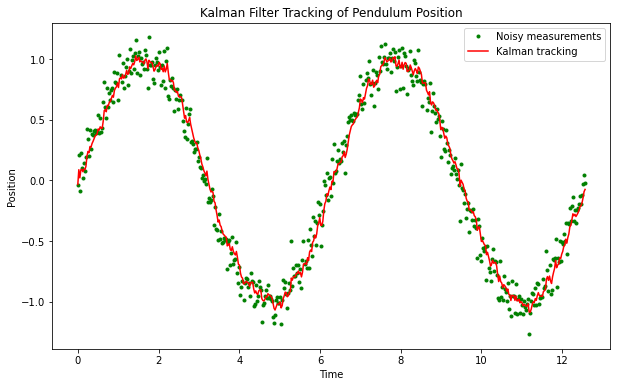

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, x, P, Q, R):
        """
        x: The initial state vector
        P: The initial covariance matrix
        Q: The process noise covariance matrix
        R: The measurement noise covariance matrix
        """
        self.x = x
        self.P = P
        self.Q = Q
        self.R = R
        self.A = np.array([[1]])  # State transition matrix (scalar for position)
        self.u = np.array([0])  # Process noise vector (scalar for position)
        self.H = np.array([[1]])  # Measurement matrix (scalar for position)

    def predict(self):
        """
        Predict the next state of the system.
        """
        self.x = self.x * self.A + self.u
        self.P = self.A * self.P * self.A + self.Q

    def update(self, y):
        """
        Update the state estimate using the measurement.
        """
        S = self.P + self.R
        K = self.P / S
        self.x = self.x + K * (y - self.x)
        self.P = (1 - K) * self.P


# Define the parameters of the pendulum
g = 9.81  # m/s^2
l = 1  # m

# Initialize the state vector
x = np.array([0])  # Initial position

# Initialize the covariance matrix
P = np.array([0.1])  # Initial covariance

# Define the process noise covariance matrix
Q = np.array([0.001])  # Reduced variance of the process noise
#Q = np.array([0.01])
#Q = np.array([0.1])
# Define the measurement noise covariance matrix
R = np.array([0.01])  # Reduced variance of the measurement noise
#R = np.array([0.1])
# Initialize the Kalman filter
kf = KalmanFilter(x, P, Q, R)

# Simulate for 2 to 3 periods
T = np.linspace(0, 2 * np.pi * 2, num=500)  # Time vector
measurements = []
x_hat = []  # To store the filtered position estimates
for t in T:
    # Calculate the true state of the pendulum
    x_true = np.sin(t)

    # Add reduced noise to the measurement
    y = x_true + np.random.randn() * np.sqrt(R)

    measurements.append(y)

    # Run the Kalman filter
    kf.predict()
    kf.update(y)
    x_hat.append(kf.x[0])  # Store the filtered position estimate

# Convert the lists to NumPy arrays for plotting
measurements = np.array(measurements)
x_hat = np.array(x_hat)

# Plot the noisy measurements and the Kalman tracking result
plt.figure(figsize=(10,6))
plt.plot(T, measurements, 'g.', label='Noisy measurements')
plt.plot(T, x_hat, 'r-', label='Kalman tracking')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title('Kalman Filter Tracking of Pendulum Position')
plt.show()


## Extended Kalman Filter

We recall the pros and cons of the EKF:

- Pros:
		- Relative simplicity, based on well-known linearization methods.
		- Maintains the simple, elegant, and computationally efficient KF update equations.
		- Good performance for such a simple method.
		- Ability to treat nonlinear process and observation models.
		- Ability to treat both additive and more general nonlinear Gaussian noise.
- Cons:
		- Performance can suffer in presence of strong nonlinearity because of the local validity of the linear approximation (valid for small perturbations around the linear term).
		- Cannot deal with non-Gaussian noise, such as discrete-valued random variables.
		- Requires differentiable process and measurement operators and evaluation of Jacobian matrices, which might be problematic in very high dimensions.

In spite of these, the EKF remains a solid filter and, as mentioned earlier, remains the basis of most critical systems, such as GPS and navigation systems.

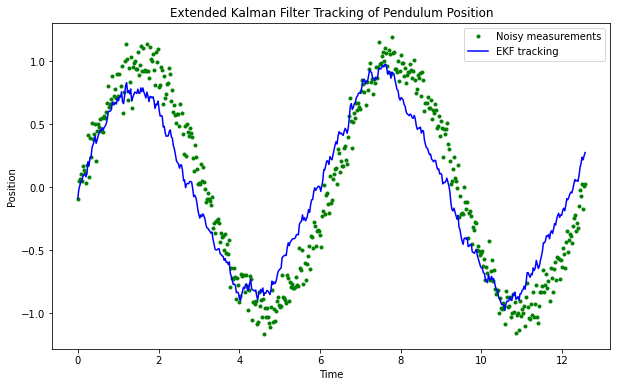

In [2]:
# use an EKF to take into account the nonlinearity

import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilter:
    def __init__(self, x, P, Q, R):
        """
        x: The initial state vector
        P: The initial covariance matrix
        Q: The process noise covariance matrix
        R: The measurement noise covariance matrix
        """
        self.x = x
        self.P = P
        self.Q = Q
        self.R = R

    def predict(self, dt):
        """
        Predict the next state of the system using the nonlinear process model.
        """
        # Nonlinear process model (pendulum equation)
        theta, theta_dot = self.x
        theta_predict = theta + theta_dot * dt
        theta_dot_predict = theta_dot - (g / l) * np.sin(theta) * dt

        self.x = np.array([theta_predict, theta_dot_predict])

        # Jacobian of the process model (A matrix)
        A = np.array([[1, dt],
                      [-(g / l) * np.cos(theta) * dt, 1]])

        # Update the covariance matrix
        self.P = np.dot(np.dot(A, self.P), A.T) + self.Q

    def update(self, y):
        """
        Update the state estimate using the nonlinear measurement model.
        """
        # Nonlinear measurement model (position measurement)
        theta, _ = self.x
        y_predict = np.sin(theta)

        # Jacobian of the measurement model (H matrix)
        H = np.array([[np.cos(theta), 0]])

        # Calculate the measurement residual
        residual = y - y_predict

        # Calculate the Kalman gain
        S = np.dot(np.dot(H, self.P), H.T) + self.R
        K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))

        # Update the state estimate and covariance matrix
        self.x = self.x + np.dot(K, residual)
        self.P = self.P - np.dot(np.dot(K, H), self.P)

# Define the parameters of the pendulum
g = 9.81  # m/s^2
l = 1  # m

# Initialize the state vector
x = np.array([0, 0])  # Initial state: [position, velocity]

# Initialize the covariance matrix
P = np.diag([0.1, 0.1])  # Initial covariance

# Define the process noise covariance matrix
Q = np.diag([0.001, 0.001])  # Variance of the process noise
#Q = np.diag([0.01, 0.01])
#Q = np.diag([0.1, 0.1])
#Q = np.diag([1.e-6, 1.e-4])
# Define the measurement noise covariance matrix
R = np.array([0.01])  # Variance of the measurement noise
#R = np.array([0.1])
# Initialize the Extended Kalman filter
ekf = ExtendedKalmanFilter(x, P, Q, R)

# Simulate for 2 to 3 periods
T = np.linspace(0, 2 * np.pi * 2, num=500)  # Time vector
measurements = []
x_hat = []  # To store the filtered position estimates
for t in T:
    # Calculate the true state of the pendulum
    theta_true = np.sin(t)

    # Add noise to the measurement
    y = theta_true + np.random.randn() * np.sqrt(R)

    measurements.append(y)

    # Run the Extended Kalman filter
    dt = T[1] - T[0]
    ekf.predict(dt)
    ekf.update(y)
    x_hat.append(ekf.x[0])  # Store the filtered position estimate

# Convert the lists to NumPy arrays for plotting
measurements = np.array(measurements)
x_hat = np.array(x_hat)

# Plot the noisy measurements and the EKF tracking result
plt.figure(figsize=(10,6))
plt.plot(T, measurements, 'g.', label='Noisy measurements')
plt.plot(T, x_hat, 'b-', label='EKF tracking')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title('Extended Kalman Filter Tracking of Pendulum Position')
plt.show()
